In [ ]:
pip install accelerate -U

#Loading Dataset

In [2]:
import pandas as pd
from pathlib import Path

df = pd.DataFrame(columns=['imgs'])

imgs, captions = [], []

img_folder = "/content/drive/MyDrive/Flickr/Flicker8k_Dataset"

caption_file = "/content/drive/MyDrive/Flickr/Caption_data/Flickr8k.token.txt"


In [3]:
with open(caption_file, "r") as f:
    content = f.read()

In [4]:
datatxt = []
for line in content.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df = pd.DataFrame(datatxt,columns=["filename","index","caption"])

In [5]:
df = df[df["index"] == "0"].copy()
df['filename'] = img_folder + '/' + df['filename']
df= df.reset_index(drop=True)

In [6]:
df.head(5)

,filename,index,caption
0,/content/drive/MyDrive/Flickr/Flicker8k_Datase...,0,a child in a pink dress is climbing up a set o...
1,/content/drive/MyDrive/Flickr/Flicker8k_Datase...,0,a black dog and a spotted dog are fighting
2,/content/drive/MyDrive/Flickr/Flicker8k_Datase...,0,a little girl covered in paint sits in front o...
3,/content/drive/MyDrive/Flickr/Flicker8k_Datase...,0,a man lays on a bench while his dog sits by him .
4,/content/drive/MyDrive/Flickr/Flicker8k_Datase...,0,a man in an orange hat starring at something .


#Loading Finetuned Image CAptioning Model

In [7]:
from transformers import ViTImageProcessor, GPT2TokenizerFast, VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/Flickr/trained1")
feature_extractor = ViTImageProcessor.from_pretrained("/content/drive/MyDrive/Flickr/trained1")
tokenizer       = GPT2TokenizerFast.from_pretrained("/content/drive/MyDrive/Flickr/trained1")

In [8]:
from PIL import Image

# maximum length for the captions
max_length = 128
sample = df.iloc[0]

# sample image
image = Image.open(sample['filename']).convert('RGB')
# sample caption
caption = sample['caption']

# apply feature extractor on the sample image
inputs = feature_extractor(images=image, return_tensors='pt')
# apply tokenizer
outputs = tokenizer(
            caption,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
        )

In [9]:
from torch.utils.data import Dataset

class LoadDataset(Dataset):
    def __init__(self, df):
        self.images = df['filename'].values
        self.captions = df['caption'].values

    def __getitem__(self, idx):

        inputs = dict()


        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt')


        caption = self.captions[idx]
        labels = tokenizer(
            caption,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]


        inputs['pixel_values'] = image['pixel_values'].squeeze()
        inputs['labels'] = labels
        return inputs

    def __len__(self):
        return len(self.images)

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)

In [12]:

num_beams = 4
model.config.num_beams = num_beams

#Testing Image Caption Generator

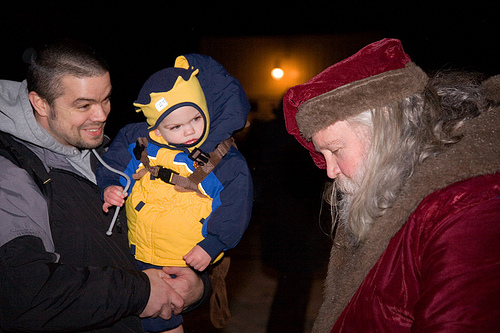

In [31]:
Image.open(test_df.iloc[1]['filename'])

In [35]:
#Verifying Original Caption
test_df.iloc[1]

filename    /content/drive/MyDrive/Flickr/Flicker8k_Datase...
index                                                       0
caption                            a child staring at santa .
Name: 4166, dtype: object

In [33]:
inputs = test_ds[1]['pixel_values']

In [34]:
#Prediciting Caption
import torch


model.eval()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model.to(device)

with torch.no_grad():

    inputs = inputs.to(device)


    outputs = model.generate(
        inputs.unsqueeze(0),
        num_beams=4,

    )
    caption = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Print the generated caption
    print(caption)


a man and two children are standing in front of a fire.


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


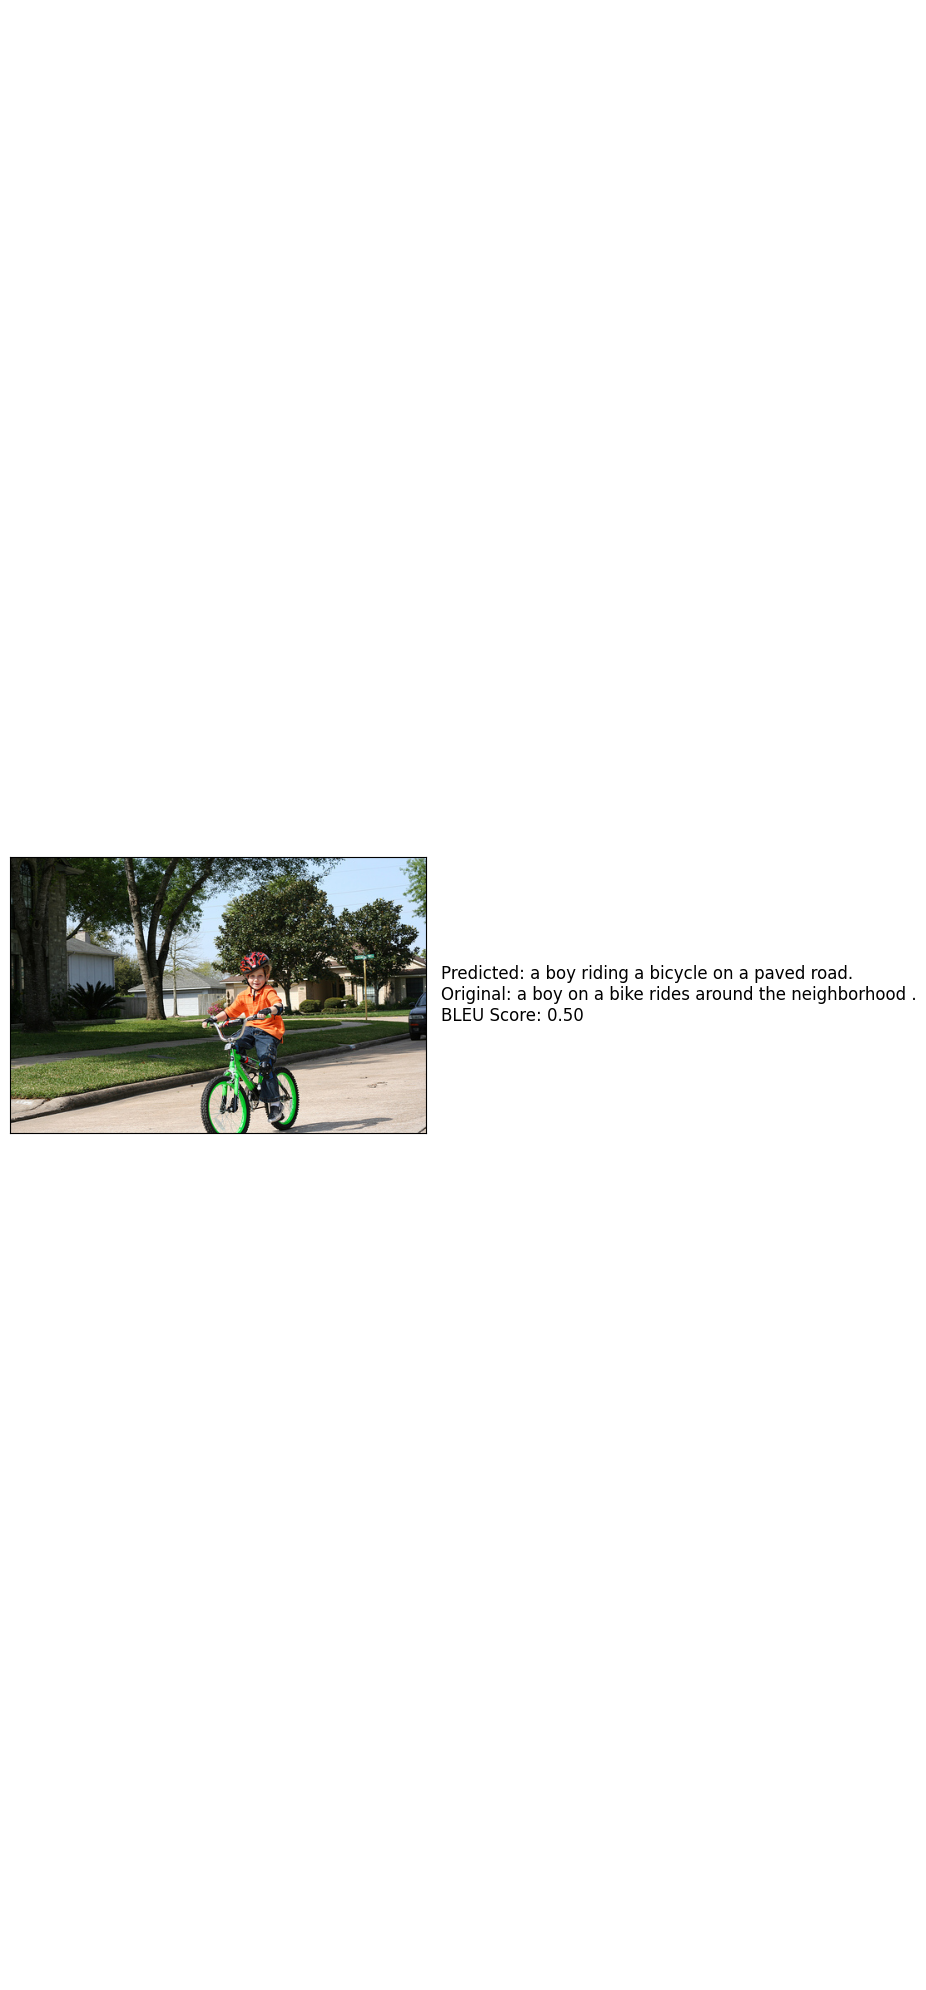

In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from torchvision import transforms

specific_indices = [240]
specific_filenames = [test_df.iloc[i]['filename'] for i in specific_indices]


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

fig = plt.figure(figsize=(10, 20))

for i, (index, filename) in enumerate(zip(specific_indices, specific_filenames), start=1):

    full_path = f"{filename}"
    image = Image.open(full_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Generate the caption
    with torch.no_grad():
        outputs = model.generate(image, num_beams=4)  # Adjust parameters as needed
        generated_caption = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Get the original caption
    reference_caption = test_df.iloc[index]['caption']

    # Calculate BLEU score
    candidate = word_tokenize(generated_caption.lower())
    reference = [word_tokenize(reference_caption.lower())]
    bleu_score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))  # Focusing on 1-grams

    # Display the image
    ax = fig.add_subplot(len(specific_indices), 2, 2*i-1, xticks=[], yticks=[])
    ax.imshow(Image.open(full_path))

    # Display BLEU score and captions
    caption_text = f"Predicted: {generated_caption}\nOriginal: {reference_caption}\nBLEU Score: {bleu_score:.2f}"
    ax = fig.add_subplot(len(specific_indices), 2, 2*i)
    plt.axis('off')
    ax.text(0, 0.5, caption_text, fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Calculating BLEU Score

In [ ]:
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
import numpy as np


model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

bleu_scores_1g = []


for i in range(min(5, len(test_ds))):
    data = test_ds[i]
    image = data['pixel_values']
    reference_caption = test_df.iloc[i]['caption']

    image = image.to(device)


    with torch.no_grad():
        outputs = model.generate(image.unsqueeze(0), num_beams=4)
        generated_caption = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Calculate BLEU score for unigrams (1-gram)
    candidate = word_tokenize(generated_caption.lower())
    reference = [word_tokenize(reference_caption.lower())]
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu_scores_1g.append(score)


average_bleu_score_1g = np.mean(bleu_scores_1g)
print(f"Average 1-gram BLEU Score: {average_bleu_score_1g}")


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/tra

Average 1-gram BLEU Score: 0.2956507033827572


#Verifying Top 3 and Bottom 3 BLEU Images

In [23]:
import pandas as pd


df_files = pd.read_csv('/content/drive/MyDrive/Flickr/original_bleu_scores_vit_1gram.txt', header=None, names=[ 'BLEU_Score'])


df_sorted = df_files.sort_values(by='BLEU_Score', ascending=False)


top_3 = df_sorted.tail(10)

# Display the bottom 3 BLEU scores and their indices
print(top_3)


      BLEU_Score
271     0.058134
127     0.055556
1363    0.052632
1569    0.052632
3       0.051455
129     0.025189
1063    0.000000
1188    0.000000
589     0.000000
1059    0.000000


In [25]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

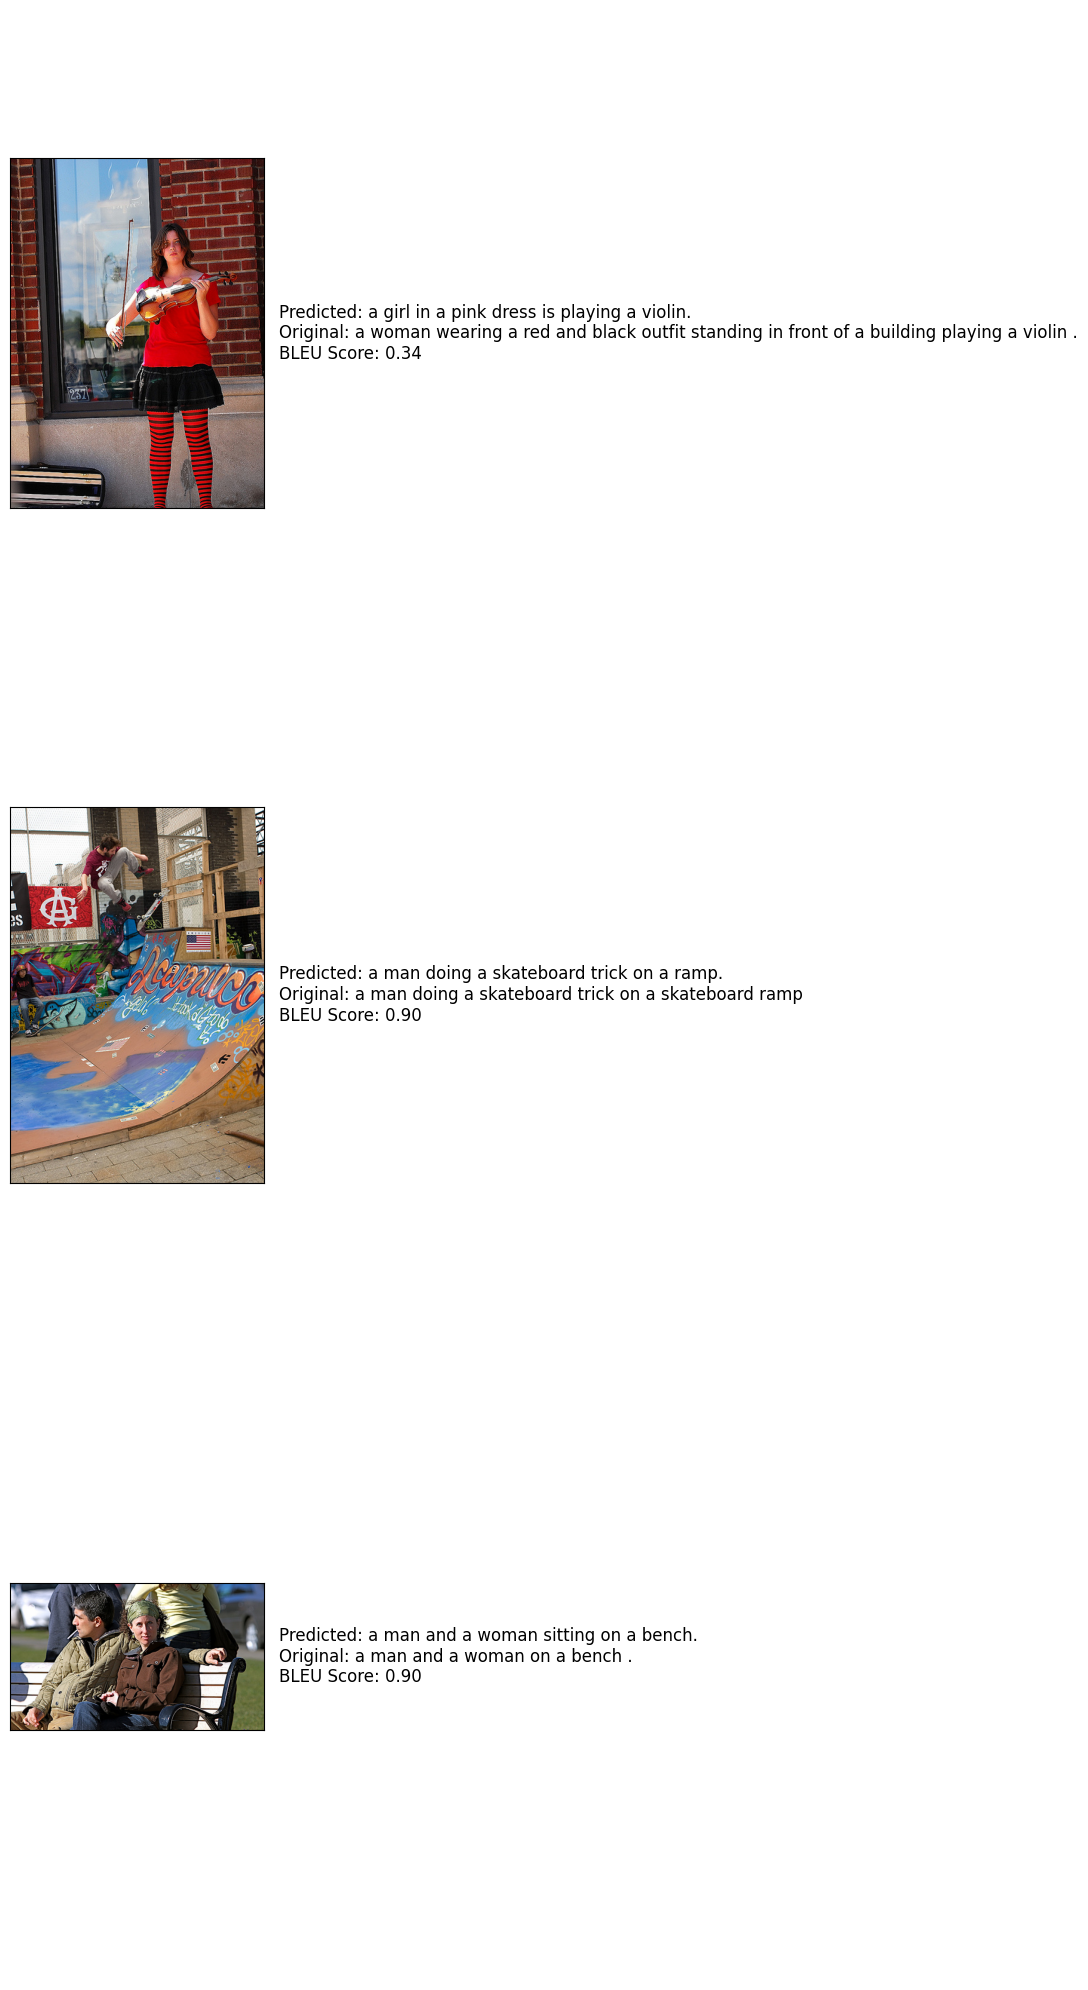

In [29]:
#Top 3 BLEU Scores
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from torchvision import transforms



specific_indices = [17, 209, 213]
specific_filenames = [test_df.iloc[i]['filename'] for i in specific_indices]


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

fig = plt.figure(figsize=(10, 20))

for i, (index, filename) in enumerate(zip(specific_indices, specific_filenames), start=1):
    # Load and preprocess the image
    full_path = f"{filename}"
    image = Image.open(full_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Generate the caption
    with torch.no_grad():
        outputs = model.generate(image, num_beams=4)  # Adjust parameters as needed
        generated_caption = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Get the original caption
    reference_caption = test_df.iloc[index]['caption']

    # Calculate BLEU score
    candidate = word_tokenize(generated_caption.lower())
    reference = [word_tokenize(reference_caption.lower())]
    bleu_score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))  # Focusing on 1-grams

    # Display the image
    ax = fig.add_subplot(len(specific_indices), 2, 2*i-1, xticks=[], yticks=[])
    ax.imshow(Image.open(full_path))

    # Display BLEU score and captions
    caption_text = f"Predicted: {generated_caption}\nOriginal: {reference_caption}\nBLEU Score: {bleu_score:.2f}"
    ax = fig.add_subplot(len(specific_indices), 2, 2*i)
    plt.axis('off')
    ax.text(0, 0.5, caption_text, fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

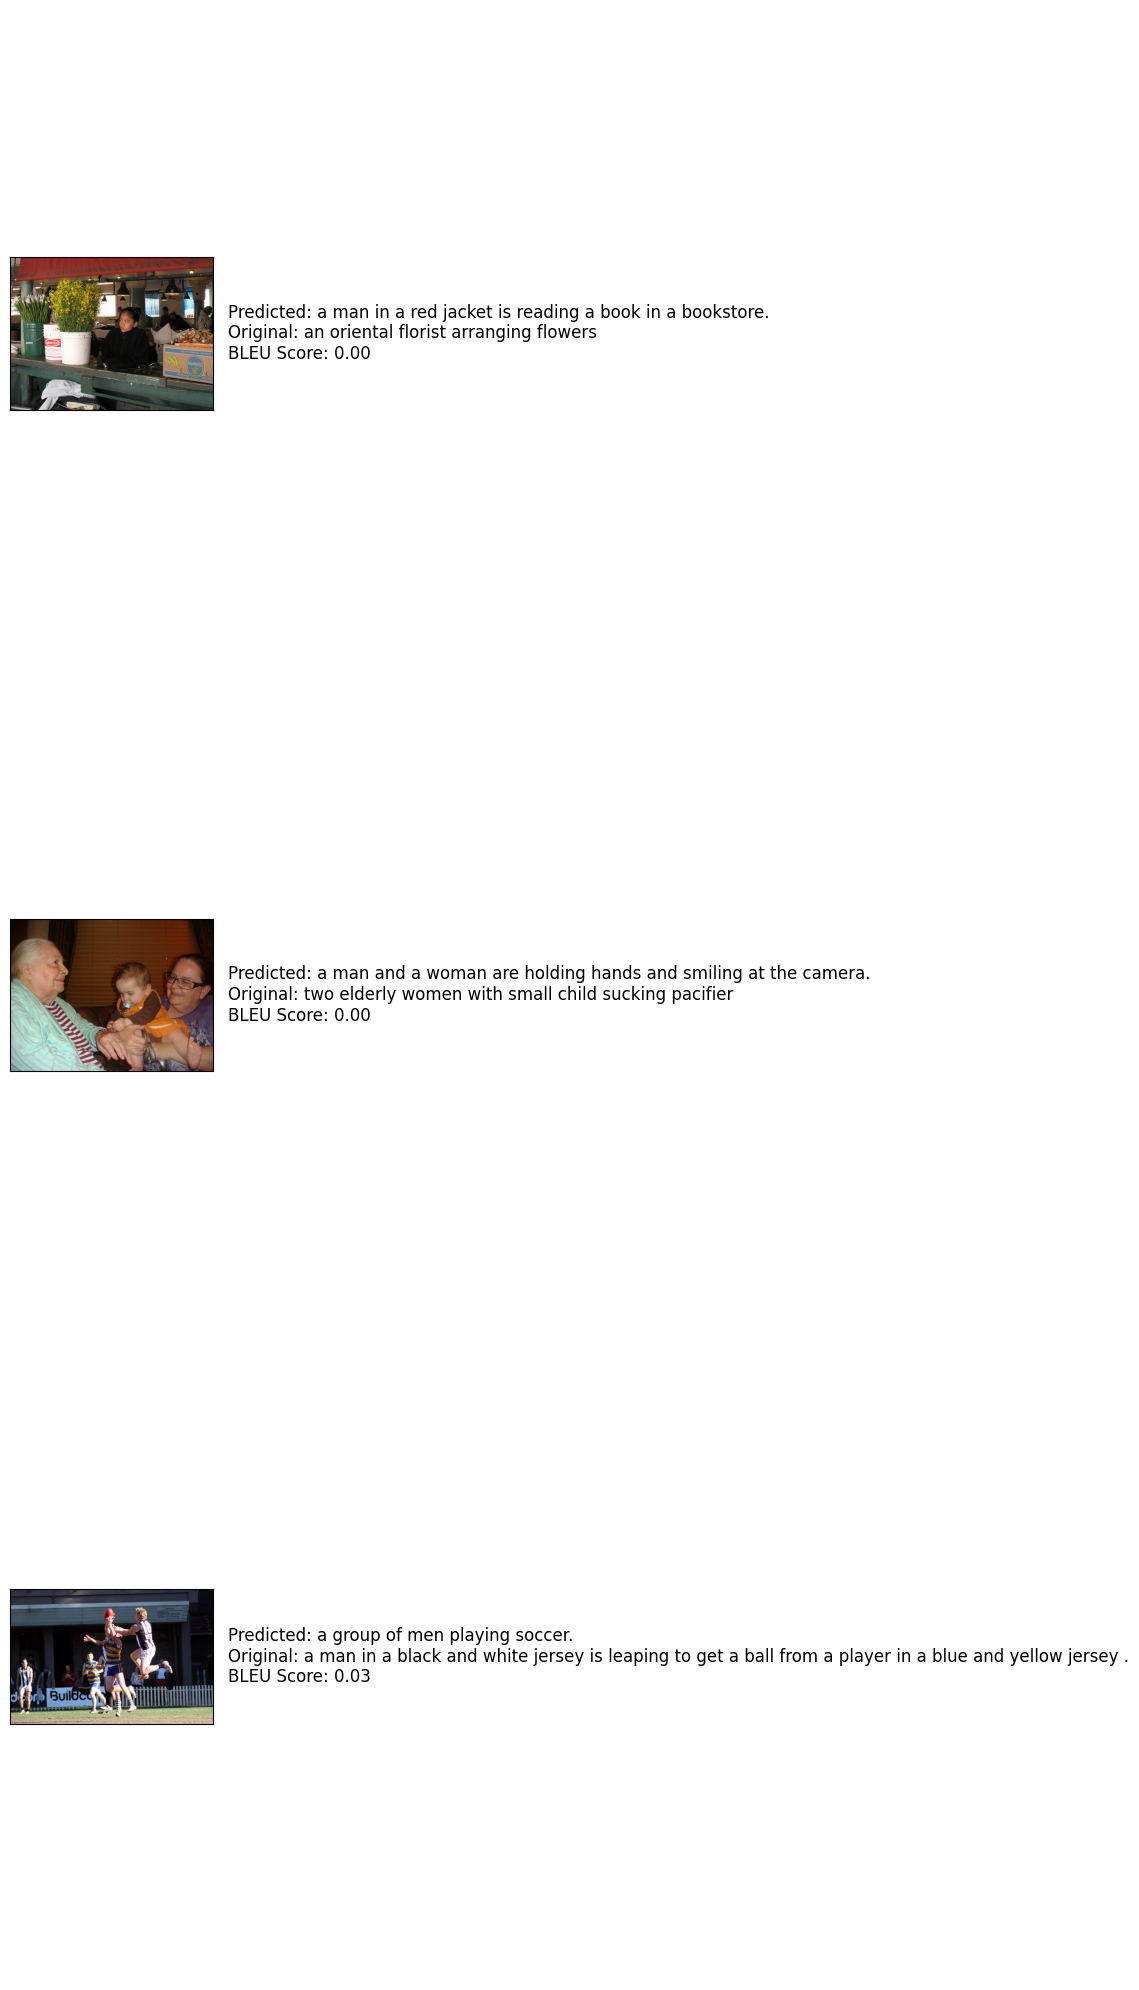

In [30]:
#Bottom 3 BLEU Score Images
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from torchvision import transforms


specific_indices = [589, 1188, 129]
specific_filenames = [test_df.iloc[i]['filename'] for i in specific_indices]

# Image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

fig = plt.figure(figsize=(10, 20))

for i, (index, filename) in enumerate(zip(specific_indices, specific_filenames), start=1):
    # Load and preprocess the image
    full_path = f"{filename}"
    image = Image.open(full_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Generate the caption
    with torch.no_grad():
        outputs = model.generate(image, num_beams=4)  # Adjust parameters as needed
        generated_caption = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Get the original caption
    reference_caption = test_df.iloc[index]['caption']

    # Calculate BLEU score
    candidate = word_tokenize(generated_caption.lower())
    reference = [word_tokenize(reference_caption.lower())]
    bleu_score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))  # Focusing on 1-grams

    # Display the image
    ax = fig.add_subplot(len(specific_indices), 2, 2*i-1, xticks=[], yticks=[])
    ax.imshow(Image.open(full_path))

    # Display BLEU score and captions
    caption_text = f"Predicted: {generated_caption}\nOriginal: {reference_caption}\nBLEU Score: {bleu_score:.2f}"
    ax = fig.add_subplot(len(specific_indices), 2, 2*i)
    plt.axis('off')
    ax.text(0, 0.5, caption_text, fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()
